In [240]:
import requests, json, os, warnings, re
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import altair as alt

# DSCI 525 - Lab 1: APIs

## Submission Instructions (10% of your lab here - read it!)
rubric={mechanics:5}
- [Follow the general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/)
- The sum of all non-optional rubrics is 100. So it is easy for you to know how much of your lab a question is worth.

### Code Quality
rubric={quality:5}

The code that you write for this assignment will be given one overall grade for code quality, see our code quality rubric as a guide to what we are looking for. Each code question will also be assessed for code accuracy (i.e., does it do what it is supposed to do?).

----

<font color="red">You can use whatever plotting library you want for this lab.</font>

## Table of Contents

- [Intro](#Intro)
  - [Exercise 0](#Exercise-0---Warm-up) -- 10% -- {accuracy:10}
- [Exercise 1](#Exercise-1)
  - [Exercise 1.0](#Exercise-1.0---A-free-helper-method)
  - [Exercise 1.1](#Exercise-1.1) -- 25% -- {accuracy:18,viz=7}
  - [Exercise 1.2](#Exercise-1.2) -- 25% -- {accuracy:18,viz=7}
  - [Exercise 1.3 (Optional)](#Exercise-1.3-(Optional))
  - [Exercise 1.4 (Optional)](#Exercise-1.4-(Optional))
  - [Exercise 1.5](#Exercise-1.5---Last-part!!!) -- 30% -- {accuracy:20,viz=10}

## Intro

You have been using the numpy package a lot, haven't you? Let's see the people that have been contributing to this package. Using Github API, let's request the list of contributors to the numpy package. Let's use all the default parameters for now.  From the [documentation](https://developer.github.com/v3/), we can see that we make all our requests to `api.github.com`. But how to request the contributors specifically? Let's go back to the documentation: [list contributors](https://developer.github.com/v3/repos/#list-contributors) (please read it - it is just like three lines). Read it? Really? Are you sure? Ok, let's move on.

So the API is saying that, to request the contributors we make a `GET` request `GET /repos/:owner/:repo/contributors`.
The `:` is placeholder for the specific values that you want. In case of [numpy repo](https://github.com/numpy/numpy), `:owner` = `numpy` and `:repo`=`numpy`. Let's make a request. 

In [2]:
domain = "https://api.github.com" # The domain name
request_contributors = "/repos/numpy/numpy/contributors" # our request

response = requests.get(domain + request_contributors)

Now, let's check it out the data we got. 

In [3]:
response.json()[0] 

{'login': 'charris',
 'id': 77272,
 'node_id': 'MDQ6VXNlcjc3Mjcy',
 'avatar_url': 'https://avatars3.githubusercontent.com/u/77272?v=4',
 'gravatar_id': '',
 'url': 'https://api.github.com/users/charris',
 'html_url': 'https://github.com/charris',
 'followers_url': 'https://api.github.com/users/charris/followers',
 'following_url': 'https://api.github.com/users/charris/following{/other_user}',
 'gists_url': 'https://api.github.com/users/charris/gists{/gist_id}',
 'starred_url': 'https://api.github.com/users/charris/starred{/owner}{/repo}',
 'subscriptions_url': 'https://api.github.com/users/charris/subscriptions',
 'organizations_url': 'https://api.github.com/users/charris/orgs',
 'repos_url': 'https://api.github.com/users/charris/repos',
 'events_url': 'https://api.github.com/users/charris/events{/privacy}',
 'received_events_url': 'https://api.github.com/users/charris/received_events',
 'type': 'User',
 'site_admin': False,
 'contributions': 4434}

Look how cool is that, the `response` object already has a built-in JSON decoder. 
Above we printed just the first contributor to be easier to read. But let's save this JSON response into a variable, and check out how many contributiors we have.

In [4]:
data = response.json()
print("Number of contributors:", len(data))

Number of contributors: 30


Hmmm, weird! Something is not right here. Is it possible that an open-source project as big as `numpy` has only 30 contributors? Let's investigate this. In the [numpy repository's page](https://github.com/numpy/numpy) we can see that the number of contributors is almost 900! 

So, what is going on here? Why didn't the API returned all the contributors? Well, Github uses [Pagination](https://developer.github.com/v3/#pagination) (again, please read this - it is very short). So, basically, by default, Github uses pagination with 30 elements per page. Oh, now things are making sense. Also, there should be pagination information in the `response`'s headers, more precisely, in the `link` field, let's check it out.

In [11]:
response.headers['link']

'<https://api.github.com/repositories/908607/contributors?page=2>; rel="next", <https://api.github.com/repositories/908607/contributors?page=14>; rel="last"'

So, in the headers of the response, the API provides the hyperlink to the next page of results. Cool!

But we also saw in [Pagination](https://developer.github.com/v3/#pagination) that we can change this default. In order to do that, all we need to do is to pass parameters to the server. This can be done by including `?param1=value` after your request. For example, we could use:

1. domain: `https://api.github.com`
2. request: `/repos/numpy/numpy/contributors`
3. parameter: `?per_page=100`

which results in https://api.github.com/repos/numpy/numpy/contributors?per_page=100 (go ahead, click on it!).

Although you can just build the URL and pass it to `requests.get`, `requests` makes it easier for you to deal with parameters. Let's change the number of pages in our request now using the `requests` library. 

In [12]:
# This is what we defined before
domain = "https://api.github.com" # The domain name
request_contributors = "/repos/numpy/numpy/contributors" # our request

# Now, we can define the set of parameter as a dictionary 
params = {"per_page": 100}

# Now we call requests
response2 = requests.get(domain + request_contributors, params)

Let's check our new data now.

In [13]:
data = response2.json()
len(data)

100

It worked, now we have 100 contributors on the first page! But how did `requests` handle this for us? No mystery. Let's check the URL used by `requests`.

In [14]:
response2.url

'https://api.github.com/repos/numpy/numpy/contributors?per_page=100'

Exactly the one we built above. All `requests` did was to merge everything together for us, so our code can be more organized. But still, pretty cool! Let's check the `login` and number of contributions of the top 10 contributors to the `numpy` library.

In [15]:
# Let's check the number of contributions of the first 10 users
for repo in data[0:10]:
    print(repo['login'] + " - " + repo['contributions'].__str__())

charris - 4434
teoliphant - 2065
cournape - 1525
eric-wieser - 1122
mattip - 1099
pearu - 1061
pv - 806
mwiebe - 759
juliantaylor - 750
rgommers - 738


Ok, now you know how to make a request to Github and also how to pass parameters with your request. One last thing before you jump to your exercises. Here we only worked with the `GET` request. But you will frequently need to use other verbs, such as

1. `PUT` - usually used to change things
2. `POST` - usually used to create things
3. `DELETE` - usually used to remove things

Also, different APIs will work differently. So, you'll always need to consult the documentation. In fact, Github has a version 4 API that is not a REST API, but a [GraphQL API](https://developer.github.com/v4/).

## Exercise 0 - Warm up
rubric={accuracy:10}

We could also fetch some statistics per contributor, take a look [here](https://developer.github.com/v3/repos/statistics/#get-contributors-list-with-additions-deletions-and-commit-counts). Your job is to get the contributors list of the same `numpy` repository with additions, deletions, and commits counts per week using the Github API. 

In [2]:
domain = "https://api.github.com" # The domain name
request_contributors = "/repos/numpy/numpy/stats/contributors" # our request

response = requests.get(domain + request_contributors)
response.url

'https://api.github.com/repos/numpy/numpy/stats/contributors'

In [ ]:
data = response.json()
data[0]

In [38]:
for repo in data[0:5]:
    a = list()
    d = list()
    c = list()
    w = list()
    author = list()
    for week in repo['weeks']:
        if ((week['a'].__int__() > 0) 
            or (week['d'].__int__() > 0)
            or (week['c'].__int__() > 0)):
            a.append(week['a'].__str__())
            d.append(week['d'].__str__())
            c.append(week['c'].__str__())
            w.append(week['w'].__str__())
    for i in range(len(a)):
        print(repo['author']['login'], 
              'user in week ', w[i], 
              'added', a[i],
              'deleted', d[i],
              'committed', c[i])

jarondl user in week  1393718400 added 2 deleted 2 committed 1
jarondl user in week  1394323200 added 1 deleted 5 committed 1
wrwrwr user in week  1474761600 added 16 deleted 3 committed 1
wrwrwr user in week  1475366400 added 23 deleted 32 committed 3
wrwrwr user in week  1475971200 added 111 deleted 0 committed 2
wrwrwr user in week  1476576000 added 1 deleted 1 committed 1
wrwrwr user in week  1477180800 added 33 deleted 33 committed 3
rth user in week  1536451200 added 34 deleted 90 committed 1
rth user in week  1538265600 added 2 deleted 2 committed 1
rth user in week  1542499200 added 25 deleted 25 committed 2
rth user in week  1543104000 added 52 deleted 136 committed 1
rth user in week  1543708800 added 57 deleted 106 committed 1
rth user in week  1546732800 added 39 deleted 1 committed 2
rth user in week  1584835200 added 3 deleted 18 committed 2
fruchart user in week  1557014400 added 121 deleted 35 committed 3
fruchart user in week  1557619200 added 64 deleted 27 committed 7

# Exercise 1

In this exercise, we are going to build a very simple python wrapper for the [Alpha Vantage API](https://www.alphavantage.co/). It is a free API to collect stock market data, however, it still requires authentication. So, get your [free API key today! ](https://www.alphavantage.co/support/#api-key) Just fill in the form and get your key (careful, the key is generated in the same webpage, just below the "Get free API key" button). Save this key, it is kind of important for this exercise. Cool! We are set. Just one note:

- **These people are kind enough to give us free access to their API, the only thing they ask is for you to "make API requests sparingly (up to 5 API requests per minute and 500 requests per day) to achieve the best server-side performance". So, let's try to follow this request.**

A useful way to work with API keys is to set environment variables with the value of the key. Then you can just retrieve them using python `os` library. Although this is a common practice, you should be aware that this is not very secure. Any application can access your environmental variable (which is the reason you can easily access them using the `os` library). To create new environment variables:

- on Windows: open Powershell and type: `[Environment]::SetEnvironmentVariable('variable_name', 'variable_value', 'User')`, where `variable_name` is the name for your variable (e.g., ALPHA_API), `variable_value` is your API key, and `Users` is specifying the scope of the variable (e.g., if you want your variable available to all the users you would use `Machine` instead. But here we don't want that). Note that the variable will be available only in the next sessions.

- on Mac/Linux: `export variable_name=variable_value`. This will make the variable available only in the current session. To add a variable persistently in Linux/Mac you need to store in the .bash_profile (but you might want to check that out).

- To access an environment variable in a python session you run:
    ```python
        import os
        os.environ['variable_name']
    ```

Although there are some wrappers already defined for Alpha Vantage API, this is for you to learn. In the future, if you find a useful API that has no wrapper in either R or Python, you could make your own wrapper, create a package and publish it. The community would be grateful. 

The idea of a wrapper is to create a set of functions to handle the requests for us, so it is easier to work with the API in a specific language.

Now, take a look at the API [documentation](https://www.alphavantage.co/documentation/).

API key: 8Q7QEMFHKONJVUVA

In [13]:
import os
os.environ['ALPHA_API']

'8Q7QEMFHKONJVUVA'

## Exercise 1.0 - A free helper method

Create a function to build and return your request. I'll give you this one for free. Feel free to change this function if you want to.

In [242]:
def data_request(params):
    url = "https://www.alphavantage.co/query"
    params['apikey'] = os.environ['ALPHA_API']

    return requests.get(url, params)

For all the following exercises use `outputsize="full"` (if relevant).

In [102]:
params = {'function':'TIME_SERIES_DAILY',
          'symbol':'IBM'}
#data = data_request(params).json()

In [241]:
def make_plot(df, title):
    """
    This will plot the dataframes that are generated for this lab.
    
    Argument :
        df: dataframe
        title: plot title
    Return
        chart : plot of the open, high, low, close
    """
    open_close_color = alt.condition("datum.open <= datum.close",
                                     alt.value("#06982d"),
                                     alt.value("#ae1325"))

    base = alt.Chart(df).encode(
        alt.X('time:T',
              axis=alt.Axis(
                  format='%m/%d/%Y',
                  labelAngle=-45,
                  title='Time'
              )
        ),
        color=open_close_color
    )

    rule = base.mark_rule().encode(
        alt.Y(
            'low:Q',
            title='Price',
            scale=alt.Scale(zero=False),
        ),
        alt.Y2('high:Q')
    )

    bar = base.mark_bar().encode(
        alt.Y('open:Q'),
        alt.Y2('close:Q')
    )

    plot = (rule + bar).properties(title = title, 
                                   width = 500, 
                                   height = 200)
    
    return plot

## Exercise 1.1
rubric={accuracy:18,viz=7}

Let's make a wrapper function to retrieve a [Stock Time Series](https://www.alphavantage.co/documentation/#time-series-data). For this exercise, you can focus only in the [daily](https://www.alphavantage.co/documentation/#daily), [weekly](https://www.alphavantage.co/documentation/#weekly), and [monthly](https://www.alphavantage.co/documentation/#monthly), periods. Write a function that receives the name of a stock, and the frequency and returns the data in a pandas' dataframe.  Then, using this function to retrieve the data, plot the time series of weekly `low` price, weekly `close` price and weekly `high` price, all in the same plot. You can pick whatever stock you want. 

(Hint: I suggest you add some meta-data to the variable storing the pandas data frame, like the stock name. For example, `data.stock = 'stock_name'`, which will be able to refer back later.)

In [212]:
def Get_TimeSeries(stock, period):
    """
    A wrapper function to obtain the the time series of a the desired stock from the Alpha Vantage API.
    
    Parameters:
    -----------
    stock: the desired stock symbol (e.g., "GOOG", "AMD", "FB", "INTC").
    period: "daily", "weekly", "monthly"
    
    Returns:
    --------
    A pandas dataframe with the columns `open`, `high`, `low`, `close`, and `volume`.
    """
    
    # Process here the parameter `period`
    # which affects the function parameter in the API
    
    if period == 'daily':
        function ='TIME_SERIES_DAILY'
    elif period == 'weekly':
        function ='TIME_SERIES_WEEKLY'
    elif period == 'monthly':
        function = 'TIME_SERIES_MONTHLY'
    
    
    # Hold the parameters
    params = {'function' : function,
              'symbol' : stock}
    
    if not data_request(params).status_code == 200:
        return print("Unable to connect with API")
    # Requesting the data
    df = pd.DataFrame(data_request(params).json())
    
    # Wrangling the data
    df1 = pd.concat([df.drop(['Time Series (Daily)'], axis=1), 
           df['Time Series (Daily)'].apply(pd.Series)], axis=1)
    df1 = df1.reset_index().drop([0,1,2,3,4,5])
    df1 = df1.drop(columns = ['Meta Data',0])
    data = df1.reset_index(drop=True).rename(columns = {'index' : 'time',
                '1. open' : 'open',
                '2. high' : 'high',
                '3. low' : 'low',
                '4. close' : 'close',
                '5. volume' : 'volume'})
    
    data.stock = stock
    return data

In [233]:
df = Get_TimeSeries('IBM','daily')
df

,time,open,high,low,close,volume
0,2020-04-08,116.3100,119.9600,115.0742,119.2900,5155987
1,2020-04-07,118.8000,119.5700,114.8700,114.9400,5592463
2,2020-04-06,110.3500,115.6300,110.1300,114.8200,7026457
3,2020-04-03,108.9200,110.0700,104.9200,106.3400,4538113
4,2020-04-02,105.3700,110.3200,105.1400,110.0000,6327540
...,...,...,...,...,...,...
94,2019-11-21,133.4000,134.1700,132.9800,133.8400,3322158
95,2019-11-20,134.0600,134.4614,132.7500,133.2000,4138165
96,2019-11-19,134.8800,135.3800,134.4600,134.5200,2995004
97,2019-11-18,134.3000,134.4800,133.2300,134.3100,3210383


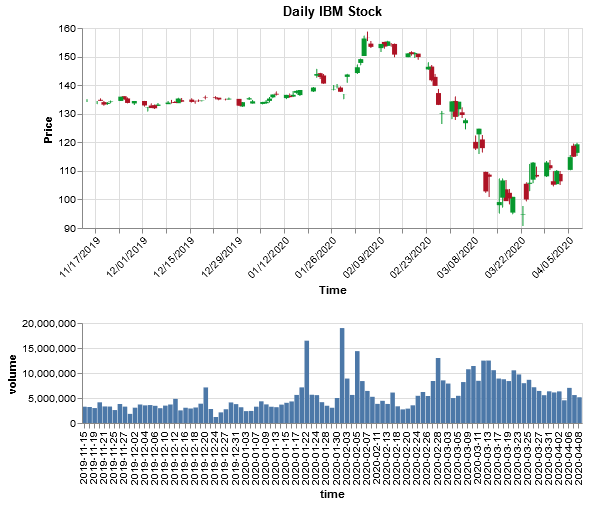

In [234]:
plot2 = alt.Chart(df).mark_bar().encode(
        alt.X('time:O'),
        alt.Y('volume:Q')).properties(width = 500, 
                                   height = 100)
make_plot(df, 'Daily IBM Stock') &  plot2

## Exercise 1.2
rubric={accuracy:18,viz:7}

Similarly to the previous exercise, let's make a wrapper function but this time to retrieve the [Foreign Exchange](https://www.alphavantage.co/documentation/#fx) data. Don't forget providing a docstring for your function. Again, you can focus on processing only `daily`, `weekly`, and `monthly`. As in Exercise 1.1, your function must return a pandas dataframe. Plot the `monthly` time series from `USD` to `CAD`. Look carefully at the documentation so you can process properly process the parameters.

In [171]:
def Get_ForeignExchange(from_currency, to_currency, period):
    """
    A wrapper function to obtain the the time series of a the desired stock from the Alpha Vantage API.
    
    Parameters:
    -----------
    from_currency : Currency to convert from. 
                    Ex: 'USD', 'CAD', 'EUR', 'INR'
    to_currency   : Currency to conver to.
                    Ex: 'USD', 'CAD', 'EUR', 'INR'
    period        : "daily", "weekly", "monthly"
    
    Returns:
    --------
    A pandas dataframe with the columns `open`, `high`, `low` and `close`
    """
    
    # Process here the parameter `period`
    # which affects the function parameter in the API
    
    if period == 'daily':
        function ='FX_DAILY'
    elif period == 'weekly':
        function ='FX_WEEKLY'
    elif period == 'monthly':
        function = 'FX_MONTHLY'
    
    # Hold the parameters
    params = {'function' : function,
              'from_symbol' : from_currency,
              'to_symbol' : to_currency}
    
    if not data_request(params).status_code == 200:
        return print("Unable to connect with API")
    # Requesting the data
    df = pd.DataFrame(data_request(params).json())
    
    df1 = df.drop(columns = ['Meta Data'])
    df1 = df1.reset_index()
    df1 = df1.drop([0,1,2,3,4,5]).reset_index(drop = True)
    df1 = pd.concat([df1.drop([df1.columns[1]], axis=1), 
                df1[df1.columns[1]].apply(pd.Series)], axis=1)
    data = df1.rename(columns = {'index' : 'time',
                          '1. open' : 'open',
                          '2. high' : 'high',
                          '3. low' : 'low',
                          '4. close' : 'close'})
    return data

In [235]:
df = Get_ForeignExchange('USD','CAD', 'daily')
df

,time,open,high,low,close
0,2020-04-10,1.3987,1.4009,1.3949,1.3952
1,2020-04-09,1.4023,1.4078,1.3927,1.3982
2,2020-04-08,1.4019,1.4082,1.3987,1.4023
3,2020-04-07,1.4141,1.4143,1.3941,1.4017
4,2020-04-06,1.4241,1.4261,1.4080,1.4140
...,...,...,...,...,...
95,2019-12-29,1.3076,1.3079,1.3067,1.3074
96,2019-12-27,1.3111,1.3121,1.3060,1.3076
97,2019-12-26,1.3160,1.3163,1.3099,1.3110
98,2019-12-25,1.3162,1.3175,1.3146,1.3159


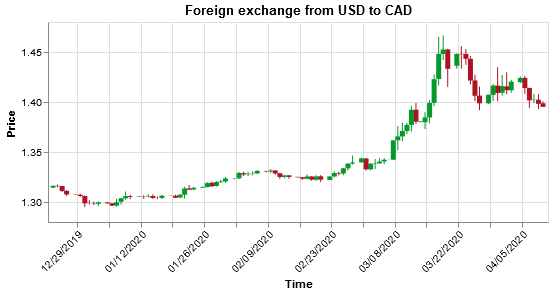

In [236]:
make_plot(df, title ='Foreign exchange from USD to CAD')

## Exercise 1.3 (Optional)
rubric={accuracy:1}

Modify your function in Exercise 1.2 to also process a [realtime exchange rate](https://www.alphavantage.co/documentation/#currency-exchange) request in case the user passes `period="live"`.

In [259]:
def Get_ForeignExchange(from_currency, to_currency, period, interval):
    """
    A wrapper function to obtain the the time series of a the desired stock from the Alpha Vantage API.
    
    Parameters:
    -----------
    from_currency : Currency to convert from. 
                    Ex: 'USD', 'CAD', 'EUR', 'INR'
    to_currency   : Currency to conver to.
                    Ex: 'USD', 'CAD', 'EUR', 'INR'
    period        : "daily", "weekly", "monthly", "live"
    interval      : 1min, 5min, 15min, 30min, 60min
    
    Returns:
    --------
    A pandas dataframe with the columns `open`, `high`, `low` and `close`
    """
    
    # Process here the parameter `period`
    # which affects the function parameter in the API
    
    if period == 'daily':
        function ='FX_DAILY'
    elif period == 'weekly':
        function ='FX_WEEKLY'
    elif period == 'monthly':
        function = 'FX_MONTHLY'
    elif period == 'live':
        function = 'FX_INTRADAY'
    
    # Hold the parameters
    params = {'function' : function,
              'from_symbol' : from_currency,
              'to_symbol' : to_currency,
              'interval'  : interval}
    
    if not data_request(params).status_code == 200:
        return print("Unable to connect with API")
    # Requesting the data
    df = pd.DataFrame(data_request(params).json())
    
    df1 = df.drop(columns = ['Meta Data'])
    df1 = df1.reset_index()
    df1 = df1.drop([0,1,2,3,4,5]).reset_index(drop = True)
    df1 = pd.concat([df1.drop([df1.columns[1]], axis=1), 
                df1[df1.columns[1]].apply(pd.Series)], axis=1)
    df1 = df1.drop(columns = 0)
    df1 = df1.drop(0)
    df1 = df1.reset_index(drop=True)
    data = df1.rename(columns = {'index' : 'time',
                          '1. open' : 'open',
                          '2. high' : 'high',
                          '3. low' : 'low',
                          '4. close' : 'close'})
    return data

In [260]:
df = Get_ForeignExchange('USD','CAD', 'live', '60min')
df

,time,open,high,low,close
0,2020-04-10 21:00:00,1.3949,1.3958,1.3949,1.3949
1,2020-04-10 20:00:00,1.3952,1.3962,1.3949,1.3950
2,2020-04-10 19:00:00,1.3961,1.3963,1.3950,1.3954
3,2020-04-10 18:00:00,1.3965,1.3968,1.3957,1.3963
4,2020-04-10 17:00:00,1.3966,1.3972,1.3962,1.3965
...,...,...,...,...,...
95,2020-04-06 22:00:00,1.4108,1.4143,1.4100,1.4140
96,2020-04-06 21:00:00,1.4109,1.4118,1.4103,1.4109
97,2020-04-06 20:00:00,1.4111,1.4116,1.4091,1.4109
98,2020-04-06 19:00:00,1.4117,1.4121,1.4097,1.4111


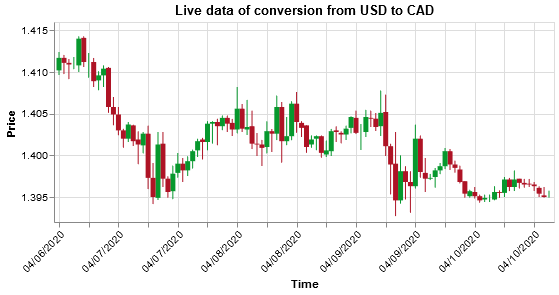

In [261]:
make_plot(df, title = "Live data of conversion from USD to CAD")

## Exercise 1.4 (Optional)
rubric={accuracy:1}

Create a wrapper function for the [cryptocurrency](https://www.alphavantage.co/documentation/#digital-currency). Again, you can consider only daily, weekly, and monthly, frequencies.

In [270]:
def Get_ForeignExchange_Crypto(symbol, market, period):
    """
    A wrapper function to obtain the the time series
    of the foreign exchange crypto from the Alpha Vantage API.
    
    Parameters:
    -----------
    symbol : Digital cryptocurrency 'BTC'.
    market : 'CNY'
    period : 'daily', 'weekly', 'monthly'
    
    Returns:
    --------
    A pandas dataframe with the columns `open`, `high`, `low` and `close`
    """
    
    # Process here the parameter `period`
    # which affects the function parameter in the API
    
    if period == 'daily':
        function ='DIGITAL_CURRENCY_DAILY'
    elif period == 'weekly':
        function ='DIGITAL_CURRENCY_WEEKLY'
    elif period == 'monthly':
        function = 'DIGITAL_CURRENCY_MONTHLY'
    
    # Hold the parameters
    params = {'function' : function,
              'symbol' : symbol,
              'period'  : period,
              'market' : market}
    
    if not data_request(params).status_code == 200:
        return print("Unable to connect with API")
    # Requesting the data
    df = pd.DataFrame(data_request(params).json())
    
    df1 = df.drop(columns = ['Meta Data'])
    df1 = df1.reset_index()
    df1 = df1.drop([0,1,2,3,4,5]).reset_index(drop = True)
    df1 = pd.concat([df1.drop([df1.columns[1]], axis=1), 
                df1[df1.columns[1]].apply(pd.Series)], axis=1)
    df1 = df1.drop(columns = 0)
    df1 = df1.drop(0)
    df1 = df1.reset_index(drop=True)
    data = df1.rename(columns = {'index' : 'time',
                          '1a. open (CNY)' : 'open (CNY)',
                          '1b. open (USD)' : 'open (USD)',
                          '2a. high (CNY)' : 'high (CNY)',
                          '2b. high (USD)' : 'high (USD)',
                          '3a. low (CNY)' : 'low (CNY)',
                          '4a. close (CNY)' : 'close (CNY)',
                          '4b. close (USD)' : 'close (USD)',
                          '5. volume' : 'volume',
                          '6. market cap (USD)' : 'market cap (USD)'})
    return data

In [271]:
Get_ForeignExchange_Crypto('BTC', 'CNY', 'daily')

,time,open (CNY),open (USD),high (CNY),high (USD),low (CNY),3b. low (USD),close (CNY),close (USD),volume,market cap (USD)
0,2020-04-11,48231.23954800,6858.92000000,48402.81790800,6883.32000000,48072.95147900,6836.41000000,48162.81916100,6849.19000000,1160.45883900,1160.45883900
1,2020-04-10,51217.12492600,7283.54000000,51302.98442500,7295.75000000,47394.86536200,6739.98000000,48231.23954800,6858.92000000,104674.62337500,104674.62337500
2,2020-04-09,51756.61229400,7360.26000000,51838.60424800,7371.92000000,49983.30775200,7108.08000000,51217.12492600,7283.54000000,61094.87241700,61094.87241700
3,2020-04-08,50610.83450800,7197.32000000,52176.69800000,7420.00000000,50278.08500000,7150.00000000,51763.78483200,7361.28000000,76059.14583800,76059.14583800
4,2020-04-07,51543.12381000,7329.90000000,52455.79411100,7459.69000000,49764.75630000,7077.00000000,50610.83450800,7197.32000000,103585.16891800,103585.16891800
...,...,...,...,...,...,...,...,...,...,...,...
964,2017-08-21,28613.71524700,4069.13000000,28968.75587800,4119.62000000,27507.31610100,3911.79000000,28240.11040000,4016.00000000,691.74306000,691.74306000
965,2017-08-20,28978.31926200,4120.98000000,29611.89345200,4211.08000000,28356.98057800,4032.62000000,28734.38265100,4086.29000000,467.08302200,467.08302200
966,2017-08-19,28889.64700300,4108.37000000,29426.32161100,4184.69000000,27072.81500000,3850.00000000,29111.92536200,4139.98000000,381.30976300,381.30976300
967,2017-08-18,30132.25405200,4285.08000000,30740.09148800,4371.52000000,27697.03676300,3938.77000000,28889.64700300,4108.37000000,1199.88826400,1199.88826400


## Exercise 1.5 - Last part!!!
rubric={accuracy:20,viz:10}

This time, just so we can also have some technical indicators to play with, create a wrapper function to retrieve some [technical indicators data](https://www.alphavantage.co/documentation/#technical-indicators). Note that some of the indicators require different parameters. So, to keep it simple, let's focus only on technical indicator with the same required parameters as `SMA`. You can assume that it is the user's responsability to use the function with an appropriate technical indicator. As usual, your function must return a pandas dataframe. Do not forget to provide a docstring for your function. Retrieve two technical indicators using your function and plot their time series (in different plots).

In [179]:
def Get_Tech_Indicators(indicator, stock, interval, time_period):
                   
    """
    A wrapper function to obtain the the time series of 
    a the desired tech indicator.
    
    Parameters:
    -----------
    indicator   : tech indicator that interested in. ex: 'SMA'
    stock       : "GOOG", "IBM"
    interval    : 'daily', 'weekly', 'monthly'
    time_period : time_period=60, time_period=200

    Returns:
    --------
    A pandas dataframe with the columns `open`, `high`, 
    `low`, `close`, and `volume`.
    """
            
    series_type = ['open', 'high', 'low', 'close']
    
    df = pd.DataFrame()

    for i in series_type:
        params = {'function':indicator, 
                  'symbol':stock , 
                  'interval':interval, 
                  'time_period': time_period, 
                  'series_type': i, 
                  'datatype':'json'}
        
    
        raw = data_request(params).json()

        raw_data = raw[list(raw.keys())[1]]
        raw_data_json = json.dumps(raw_data)
        data = pd.read_json(raw_data_json, orient="index")
        
        data.columns = [i]
                   
        df = pd.concat([df, data], axis = 1)
    df = df.reset_index()
    
    return df

In [237]:
df = Get_Tech_Indicators("SMA", "IBM", "daily", "10")
df = df.rename(columns = {'index' : 'time'})
df

,time,open,high,low,close
0,2000-04-24,112.117,114.3230,108.3420,110.973
1,2000-04-25,110.292,113.0860,106.8300,110.011
2,2000-04-26,109.380,112.3180,105.9490,109.124
3,2000-04-27,108.368,111.6680,105.6490,108.811
4,2000-04-28,108.318,111.5060,105.6610,108.899
...,...,...,...,...,...
5018,2020-04-03,105.630,109.8488,103.8426,107.236
5019,2020-04-06,107.205,111.6378,105.7996,109.241
5020,2020-04-07,109.086,112.9908,107.3606,110.187
5021,2020-04-08,110.169,113.7390,108.5850,111.531


In [ ]:
alt.data_transformers.disable_max_rows()

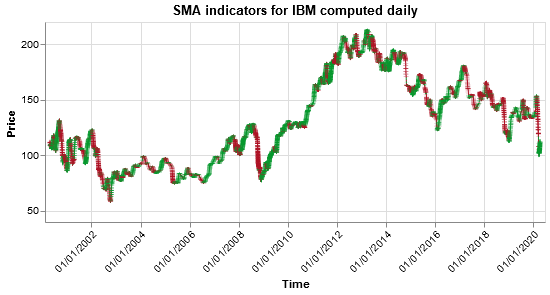

In [238]:
make_plot(df, title = 'SMA indicators for IBM computed daily')

## Final Comments

This lab is just to give you a taste of what you can do with APIs.There are tons of APIs out in the wild. Take a look at [this Github page](https://github.com/toddmotto/public-apis) for example. Now, APIs are not just for connecting to data sources. For example, there's a [Google Calendar API](https://developers.google.com/google-apps/calendar/) for programmatically interacting with Google Calendar, an [eBay API](https://go.developer.ebay.com/what-ebay-api) for interacting with eBay, etc. The Slack API allows a user to programmatically join channels. The GitHub API also isn't just for grabbing data; you can use it to programmatically open issues, make commits, etc. This is actually how we use it here in MDS. Imagine if we had to create repositories for each student manually? 

Always take a look at the documentation of the API you are going to use and have fun!